# Simulation of LaFeW3O12 using abTEM,

In [41]:
# Clean start: reset all major packages
!pip uninstall -y numpy cupy abtem zarr

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: abtem 1.0.6
Uninstalling abtem-1.0.6:
  Successfully uninstalled abtem-1.0.6
Found existing installation: zarr 3.0.8
Uninstalling zarr-3.0.8:
  Successfully uninstalled zarr-3.0.8


In [42]:
# STEP 2: Reinstall only (Colab reset clears previous installs)
!pip install numpy==1.26.4
!pip install cupy-cuda117   # For Colab’s CUDA 11.7
!pip install abtem #zarr
!pip install zarr==2.14.2

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ERROR: Could not find a version that satisfies the requirement cupy-cuda117 (from versions: none)
ERROR: No matching distribution found for cupy-cuda117
  Using cached abtem-1.0.6-py3-none-any.whl.metadata (1.9 kB)
  Using cached zarr-3.0.8-py3-none-any.whl.metadata (10.0 kB)
Using cached abtem-1.0.6-py3-none-any.whl (366 kB)
Using cached zarr-3.0.8-py3-none-any.whl (205 kB)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 7.0 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


**Restart Runtime after installation**

In [1]:
import numpy as np
import cupy

import matplotlib.pyplot as plt

import abtem
from abtem.detectors import AnnularDetector, FlexibleAnnularDetector
from abtem import stack
from abtem import GridScan

import dask.config

from ase.io import read
from ase.build import surface
from ase.geometry import cell_to_cellpar


In [67]:
# Force CuPy context init first
_ = cupy.zeros(1)  # Touch GPU context early

# Now safe to check GPU inside try block
try:
    gpu_count = cupy.cuda.runtime.getDeviceCount()
    if gpu_count > 0:
        print(f"✅ GPU available (count: {gpu_count}) — using CuPy FFT")
        abtem.config.set({
            "device": "gpu",
            "fft": "cupy",
            "dask.chunk-size-gpu": "512 MB",
            "cupy.fft-cache-size": "1024 MB"
        })
    else:
        raise RuntimeError("No GPU found")
except Exception as e:
    print(f"⚠️ No usable GPU or CuPy error: {e} — falling back to CPU/FFTW.")
    abtem.config.set({
        "device": "cpu",
        "fft": "fftw"
    })

dask.config.set({"num_workers": 1})

print("CuPy version:", cupy.__version__)
print("Available GPU count:", cupy.cuda.runtime.getDeviceCount())

✅ GPU available (count: 1) — using CuPy FFT
CuPy version: 13.3.0
Available GPU count: 1


# Building and oreinting cell

In [3]:
from google.colab import files
uploaded = files.upload()

Saving relaxed_positions_only.cif to relaxed_positions_only (1).cif


In [68]:
# Load your atomic structure (adjust the file path as needed)
bulk_atoms = read("relaxed_positions_only.cif")

In abTEM:

The beam always travels along z direction (the 3rd vector).

So you must ensure your desired zone axis is along that 3rd vector.

In [46]:
# Align the zone axis;
atoms = surface(bulk_atoms, indices=(1, 0, 0), layers=4, periodic=True)

# Rotate structure to align [100] with z
atoms.rotate('x', 'z')  # rotate so beam || [100]

atoms.wrap()
#exapnd the lattice to create a supercell
# the beam will travel along [100] (z direction in abTEM). The c axis also ddefines the thickness.
atoms = atoms.repeat((2, 2, 1))

# Confirm result
print("Rotated cell vectors (Å):")
print(atoms.cell)

#Check atom y positions:
y_coords = [atom.position[1] for atom in atoms]
print(f"Y range: min={min(y_coords):.2f}, max={max(y_coords):.2f}")

Rotated cell vectors (Å):
Cell([12.3196, 20.1644, 21.338173128925536])
Y range: min=0.01, max=20.16


### Translation

Atoms start just above 0 Å and extend all the way up to the full cell height. This means the slab is touching the bottom (y ≈ 0) and reaches the top edge of the box. simulation box height is: Cell[1,1] = 20.1644 Å.

This can cause:

Uneven vacuum spacing (if any)

Asymmetrical image contrast (e.g. top atoms getting more beam exposure)

Poor simulation symmetry if repeated



In [69]:
#If the slab is not roughly centered (e.g. min > 0, max far below cell height), then apply:
atoms.translate((0, -atoms.get_center_of_mass()[1] + atoms.cell[1, 1] / 2, 0))

In [70]:
#Check atom y positions:
y_coords = [atom.position[1] for atom in atoms]
print(f"Y range: min={min(y_coords):.2f}, max={max(y_coords):.2f}")

Y range: min=-0.17, max=19.98


In [71]:
# Create a potential object for the system
#Reducing the sampling value (e.g., from 0.1 to 0.05 or smaller) will create larger images with more data points per pixel.
potential = abtem.Potential(atoms, sampling=0.025)

In [72]:
# Rotate the structure to align with the desired zone axis (e.g., [1, 0, 0])
zone_axis = np.array([1, 0, 0 ])  # Desired zone axis (Miller indices or custom direction)

In [85]:
# Define the probe with energy, semiangle, spherical aberration (Cs), and defocus
#The semiangle_cutoff in abTEM defines the maximum simulated scattering angle in milliradians (mrad).
#Any detector angle beyond that (e.g., outer=180) will contain no signal because the probe simply doesn't scatter to that angle.
probe = abtem.Probe(
    energy=300e3,             #300 kV
    semiangle_cutoff=20,      #define proper semi angle cutoff for detectors
    Cs=1.3e-3 * 1e10,         #1.3mm in Angstrom as in JEOL GrandARM
    defocus=30             #defocus="scherzer"
)

In [86]:
# Match probe grid to potential
probe.grid.match(potential)

# Print defocus and Full Width Half Maximum (FWHM) of the probe
print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

#check the max angle for the detectors. They should not exceed this value.
print("Probe semiangle cutoff:", probe.semiangle_cutoff)

#confirm the simulation window (in angstroms):
print("Cell dimensions [Å]:", atoms.cell.lengths())

print("Cell vectors (Å):")
print(atoms.cell)

defocus = 30 Å
FWHM = 0.6234615445137024 Å
Probe semiangle cutoff: 20
Cell dimensions [Å]: [12.3196     20.1644     21.33817313]
Cell vectors (Å):
Cell([12.3196, 20.1644, 21.338173128925536])


## FLEXIBLE SCAN (4D-STEM)

FlexibleAnnularDetector records the full diffraction pattern (intensity vs. scattering angle) at each probe position → this is the 4D-STEM dataset:

2D: probe scan positions (x, y)

2D: detector plane (kx, ky) or angle

This allows you to integrate any annular or custom region afterward without needing to re-simulate the probe.

In [ ]:
# Set up the scanning region with a grid scan
#GridScan is used to define the region over which the simulation is performed. These coordinates specify the region of interest or the portion of the specimen that is being scanned.
#If you set start=(0, 0) and end=(1, 1), the grid will scan the entire unit cell (from one corner to the opposite corner).
#grid_scan = abtem.GridScan(start=(0, 0), end=(3 / 5, 2 / 3),sampling=probe.aperture.nyquist_sampling, fractional=True, potential=potential,)

In [ ]:
grid_scan = abtem.GridScan(
    start=(0, 0), end=(1, 1),
    sampling=probe.aperture.nyquist_sampling / 2,  # Higher resolution
    fractional=True,
    potential=potential,
)

FlexibleAnnularDetector records the full diffraction pattern (intensity vs.
scattering angle) at each probe position → this is the 4D-STEM dataset:

2D: probe scan positions (x, y)

2D: detector plane (kx, ky) or angle

This allows you to integrate any annular or custom region afterward without needing to re-simulate the probe.

In [ ]:
# Run a flexible scan to try different angle ranges
flex_detector = FlexibleAnnularDetector()
flex_scan = probe.scan(potential, scan=grid_scan, detectors=flex_detector)
flex_scan.compute()

[###############                         ] | 38% Completed | 43m 14s


KeyboardInterrupt: 

In [ ]:
flex_scan.save("flex_scan.zarr")

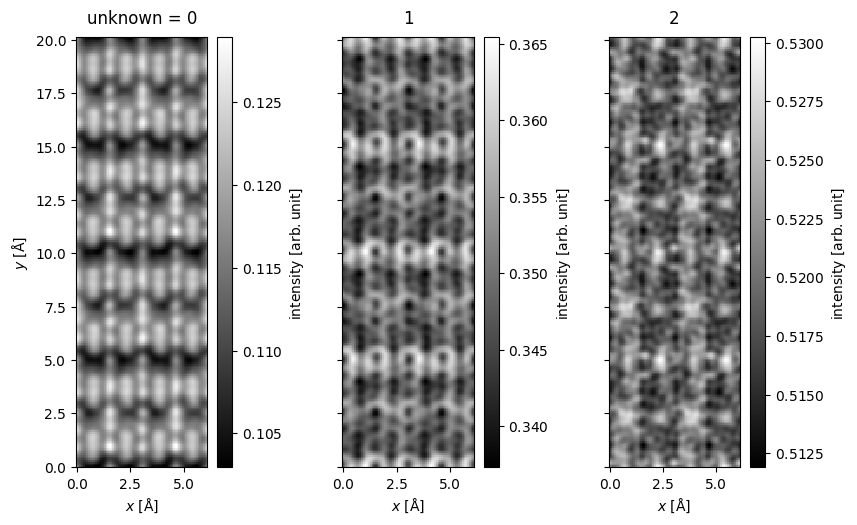

In [ ]:
# INTEGRATE TO GET DIFFERENT SIGNALS ---
# Manually integrate angle ranges from the flexible detector
bf_measurement    = flex_scan.integrate_radial(0, 10)     # ABF
maadf_measurement = flex_scan.integrate_radial(10, 20)    # MAADF
haadf_measurement = flex_scan.integrate_radial(20, 30)    # HAADF

# Stack measurements as a list
measurement_stack = stack([
    bf_measurement,
    maadf_measurement,
    haadf_measurement
])

fig = measurement_stack.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
    cmap="gray",
    return_figure=True
)
fig.savefig("stacked_measurements.png", dpi=300)
files.download("stacked_measurements.png")

## SWITCH TO PRODUCTION DETECTORS, Fast STEM Imaging

In [87]:
# Now use specific named detectors for reproducible runs
abf_detector   = AnnularDetector(inner=12, outer=19)   # no 'name='
haadf_detector = AnnularDetector(inner=30, outer=32)

# Setup scan
grid_scan_fast = GridScan(
    start=(0, 0), end=(1, 1),
    sampling=probe.aperture.nyquist_sampling / 3.5,  # 3 higher resolution, 2 less resolution
    fractional=True,
    potential=potential
)

# Scan with your defined detectors (ABF and HAADF only)
measurements_fast = probe.scan(
    potential,
    scan=grid_scan_fast,
    detectors=[abf_detector, haadf_detector]
)


In [88]:
measurements_fast.compute()

[########################################] | 100% Completed | 10m 14s


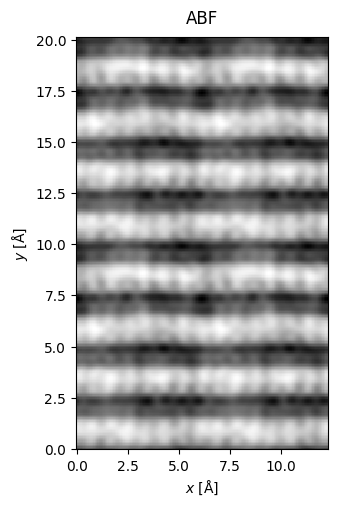

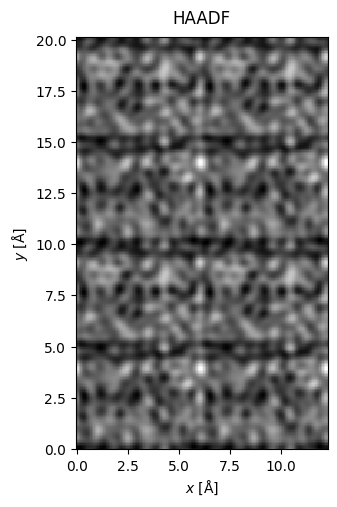

In [89]:
# Stack the measurements with labels
named_stack = stack(measurements_fast, ("ABF", "HAADF"))

# Show ABF and HAADF images
named_stack[0].show(cmap="gray", title="ABF")
named_stack[1].show(cmap="gray", title="HAADF")

In [90]:
from google.colab import files

# ✅ Use CPU + FFTW backend for post-processing
abtem.config.set({"device": "cpu", "fft": "fftw"})

# ✅ Labels for your detectors
labels = ["ABF", "HAADF"]

# ✅ Step 1: Interpolate + filter
interpolated = [m.interpolate(0.05) for m in named_stack]
filtered = [m.gaussian_filter(0.3) for m in interpolated]

# ✅ Step 2: Save and download raw + filtered images
for label, raw_img, filt_img in zip(labels, measurements_fast, filtered):
    # --- Raw image ---
    raw_array = raw_img.array
    np.save(f"{label.lower()}_raw.npy", raw_array)
    plt.imshow(raw_array, cmap="gray")
    plt.title(f"{label} (raw)")
    plt.colorbar()
    plt.savefig(f"{label.lower()}_raw.png", dpi=300, bbox_inches='tight')
    plt.close()

    files.download(f"{label.lower()}_raw.npy")
    files.download(f"{label.lower()}_raw.png")
    print(f"⬇️ Downloaded raw {label}")

    # --- Filtered image ---
    filt_array = filt_img.array
    np.save(f"{label.lower()}_filtered.npy", filt_array)
    plt.imshow(filt_array, cmap="gray")
    plt.title(f"{label} (filtered)")
    plt.colorbar()
    plt.savefig(f"{label.lower()}_filtered.png", dpi=300, bbox_inches='tight')
    plt.close()

    files.download(f"{label.lower()}_filtered.npy")
    files.download(f"{label.lower()}_filtered.png")
    print(f"⬇️ Downloaded filtered {label}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloaded raw ABF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloaded filtered ABF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloaded raw HAADF


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloaded filtered HAADF


In [99]:
import ipywidgets as widgets
from IPython.display import display

abf_measurement = measurements_fast[0]  # assuming ABF is the first
abf_array = abf_measurement.array

def show_abf(vmin=0.52, vmax=0.54):
    plt.figure(figsize=(6, 4))
    plt.imshow(abf_array, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title("ABF with adjustable contrast")
    plt.colorbar()
    plt.show()

# Use histogram to decide range
print("ABF range:", np.min(abf_array), "to", np.max(abf_array))

widgets.interact(show_abf, vmin=(0.50, 0.60, 0.001), vmax=(0.51, 0.62, 0.001))



ABF range: 0.5185257 to 0.5427642


interactive(children=(FloatSlider(value=0.52, description='vmin', max=0.6, min=0.5, step=0.001), FloatSlider(v…

<function __main__.show_abf(vmin=0.52, vmax=0.54)>